In [1]:
import os
import requests
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
import geopandas as gpd
from shapely.geometry import Point

In [2]:
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("EPA_AirQuality_Daily_Analysis") \
    .master("local[*]") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "100") \
    .getOrCreate()

spark

In [3]:
# Download daily data from EPA AQS
def download_epa_daily_data(year, parameter_code="88101", data_dir="data"):
    """
    Download daily air quality data from EPA AQS for a specific year and parameter code.
    Default parameter code 88101 is for PM2.5.
    """
    base_url = "https://aqs.epa.gov/aqsweb/airdata/"
    url = f"{base_url}daily_{parameter_code}_{year}.zip"
    
    os.makedirs(data_dir, exist_ok=True)
    zip_path = os.path.join(data_dir, f"daily_{parameter_code}_{year}.zip")
    csv_path = os.path.join(data_dir, f"daily_{parameter_code}_{year}.csv")
    
    # Download if not already exists
    if not os.path.exists(csv_path):
        print(f"Downloading {year} data...")
        response = requests.get(url)
        with open(zip_path, 'wb') as f:
            f.write(response.content)
        
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
        
        os.remove(zip_path)
    
    return csv_path

# Download data for multiple years
years = range(2020, 2025)  # Example: 2020-2024
daily_files = [download_epa_daily_data(year) for year in years]

In [7]:
# Load all daily files into a single DataFrame
daily_dfs = [spark.read.csv(file, header=True, inferSchema=True) for file in daily_files]
aq_df = daily_dfs[0]
for df in daily_dfs[1:]:
    aq_df = aq_df.union(df)
    
aq_df.printSchema()

root
 |-- State Code: integer (nullable = true)
 |-- County Code: integer (nullable = true)
 |-- Site Num: integer (nullable = true)
 |-- Parameter Code: integer (nullable = true)
 |-- POC: integer (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Datum: string (nullable = true)
 |-- Parameter Name: string (nullable = true)
 |-- Sample Duration: string (nullable = true)
 |-- Pollutant Standard: string (nullable = true)
 |-- Date Local: date (nullable = true)
 |-- Units of Measure: string (nullable = true)
 |-- Event Type: string (nullable = true)
 |-- Observation Count: integer (nullable = true)
 |-- Observation Percent: double (nullable = true)
 |-- Arithmetic Mean: double (nullable = true)
 |-- 1st Max Value: double (nullable = true)
 |-- 1st Max Hour: integer (nullable = true)
 |-- AQI: integer (nullable = true)
 |-- Method Code: integer (nullable = true)
 |-- Method Name: string (nullable = true)
 |-- Local Site Name: string (nu

In [9]:
# Select and rename relevant columns
aq_df = aq_df.select(
    col("State Name").alias("state"),
    col("County Name").alias("county"),
    col("Parameter Name").alias("pollutant"),
    col("Date Local").alias("date"),
    col("Arithmetic Mean").alias("value"),
    col("Units of Measure").alias("unit"),
    col("Latitude").alias("latitude"),
    col("Longitude").alias("longitude")
)

In [10]:
# Cache the DataFrame for performance
aq_df.cache()

# Show some rows
aq_df.show(5, truncate=False)

+-------+-------+------------------------+----------+-----+---------------------------+---------+----------+
|state  |county |pollutant               |date      |value|unit                       |latitude |longitude |
+-------+-------+------------------------+----------+-----+---------------------------+---------+----------+
|Alabama|Baldwin|PM2.5 - Local Conditions|2020-01-01|11.6 |Micrograms/cubic meter (LC)|30.497478|-87.880258|
|Alabama|Baldwin|PM2.5 - Local Conditions|2020-01-04|3.2  |Micrograms/cubic meter (LC)|30.497478|-87.880258|
|Alabama|Baldwin|PM2.5 - Local Conditions|2020-01-07|3.3  |Micrograms/cubic meter (LC)|30.497478|-87.880258|
|Alabama|Baldwin|PM2.5 - Local Conditions|2020-01-10|9.3  |Micrograms/cubic meter (LC)|30.497478|-87.880258|
|Alabama|Baldwin|PM2.5 - Local Conditions|2020-01-13|6.9  |Micrograms/cubic meter (LC)|30.497478|-87.880258|
+-------+-------+------------------------+----------+-----+---------------------------+---------+----------+
only showing top 5 

In [12]:
# Data Quality Checks
def check_missing_values(df):
    """Check for missing values in all columns with proper type handling"""
    print("Missing values per column:")
    
    numeric_exprs = [
        count(when(isnan(c) | col(c).isNull(), c)).alias(c) 
        for c in df.columns 
        if isinstance(df.schema[c].dataType, (DoubleType, FloatType))
    ]
    
    other_exprs = [
        count(when(col(c).isNull(), c)).alias(c) 
        for c in df.columns 
        if not isinstance(df.schema[c].dataType, (DoubleType, FloatType))
    ]
    
    missing_counts = df.select(numeric_exprs + other_exprs)
    missing_counts.show()

check_missing_values(aq_df)

# Basic statistics for numeric columns
numeric_cols = [
    f.name for f in aq_df.schema.fields 
    if isinstance(f.dataType, (DoubleType, FloatType, IntegerType, LongType))
]

if numeric_cols:
    aq_df.select(numeric_cols).describe().show()

# Check data distribution by pollutant
aq_df.groupBy("pollutant").count().show()

# Check value ranges for measurement values
aq_df.select(
    min("value").alias("min_value"),
    max("value").alias("max_value"),
    mean("value").alias("avg_value"),
    stddev("value").alias("stddev_value")
).show()

# Additional data quality checks
print("Data quality metrics:")

# Check for invalid dates
aq_df.select(
    count(when(col("date").isNull(), True)).alias("null_dates"),
    min("date").alias("earliest_date"),
    max("date").alias("latest_date")
).show()

# Check for invalid coordinates
aq_df.select(
    count(when((col("latitude") < -90) | (col("latitude") > 90), True)).alias("invalid_latitudes"),
    count(when((col("longitude") < -180) | (col("longitude") > 180), True)).alias("invalid_longitudes")
).show()

# Check for negative values where they shouldn't exist
aq_df.select(
    count(when(col("value") < 0, True)).alias("negative_measurements")
).show()

# Check for duplicate records
print("Potential duplicate records:")
aq_df.groupBy("state", "county", "pollutant", "date", "latitude", "longitude").count().where("count > 1").show()

#Drop Duplicate Rows
aq_df =aq_df.drop_duplicates()

Missing values per column:
+-----+--------+---------+-----+------+---------+----+----+
|value|latitude|longitude|state|county|pollutant|date|unit|
+-----+--------+---------+-----+------+---------+----+----+
|    0|       0|        0|    0|     0|        0|   0|   0|
+-----+--------+---------+-----+------+---------+----+----+

+-------+------------------+-----------------+------------------+
|summary|             value|         latitude|         longitude|
+-------+------------------+-----------------+------------------+
|  count|           3637478|          3637478|           3637478|
|   mean|  8.01048191038808|38.40670028108452|-94.17166304138745|
| stddev|7.7914237668034785|5.508486935841238|17.601331635458028|
|    min|        -22.129167|        17.712474|        -159.36624|
|    max|        824.104167|         64.84593|        -64.784868|
+-------+------------------+-----------------+------------------+

+--------------------+-------+
|           pollutant|  count|
+--------------

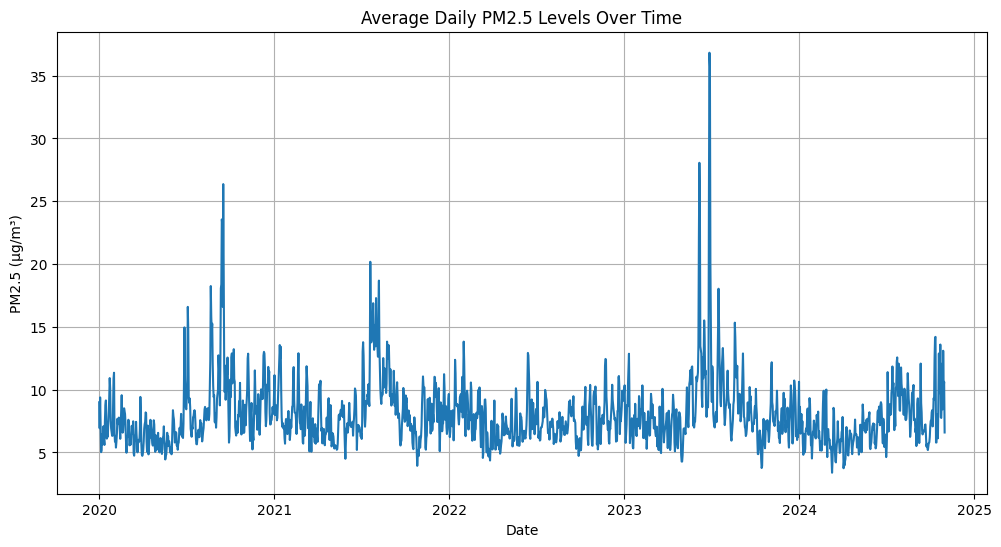

In [8]:
# Data Visualization

# Convert to Pandas for visualization (for smaller datasets)
aq_pd = aq_df.sample(fraction=0.1).toPandas()

# Time series of PM2.5 levels
plt.figure(figsize=(12, 6))
aq_pd.groupby('date')['value'].mean().plot()
plt.title("Average Daily PM2.5 Levels Over Time")
plt.ylabel("PM2.5 (µg/m³)")
plt.xlabel("Date")
plt.grid(True)
plt.show()

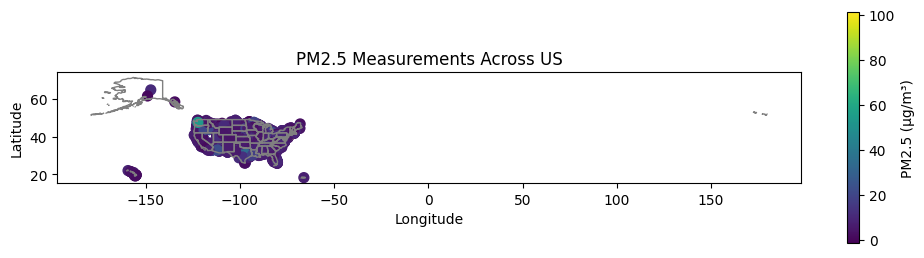

In [9]:
# Geographic visualization (using a sample)
sample = aq_pd.sample(1000)
geometry = [Point(xy) for xy in zip(sample['longitude'], sample['latitude'])]
gdf = gpd.GeoDataFrame(sample, geometry=geometry)

# Load US states shapefile
us_states = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip")

fig, ax = plt.subplots(figsize=(12, 3))
us_states.boundary.plot(ax=ax, linewidth=1, color='gray')
gdf.plot(ax=ax, markersize=50, column='value', cmap='viridis', 
         legend=True, legend_kwds={'label': "PM2.5 (µg/m³)"})
plt.title("PM2.5 Measurements Across US")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Root Mean Squared Error (RMSE): 7.364110636018379
R^2: 0.0810771804800755


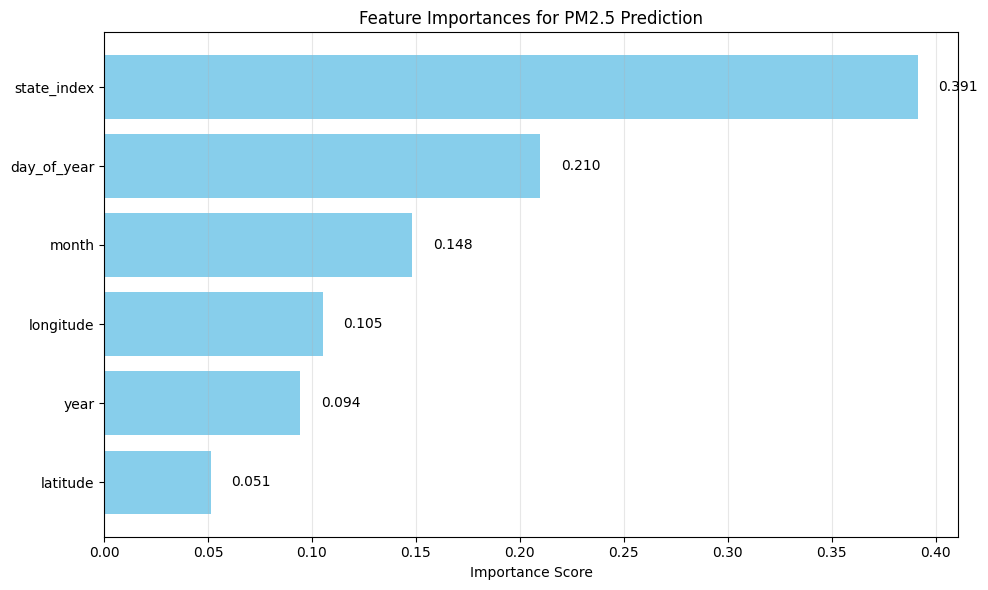

In [15]:
# Machine Learning Pipeline - Predict PM2.5 levels

# Prepare data for ML
ml_df = aq_df.select(
    col("value").alias("label"),
    col("latitude"),
    col("longitude"),
    year(col("date")).alias("year"),
    month(col("date")).alias("month"),
    dayofyear(col("date")).alias("day_of_year"),
    col("state")
).filter(col("value").isNotNull())

# 2. Lag features with proper partitioning
#window_spec = Window.partitionBy("state","year","month").orderBy("day_of_year")
#ml_df = ml_df.withColumn("prev_day_value", lag("label", 1).over(window_spec))
    
# 3. Handle nulls
#ml_df = ml_df.na.fill(0, subset=["prev_day_value"])

# Index state names
state_indexer = StringIndexer(inputCol="state", outputCol="state_index")

# Assemble features
assembler = VectorAssembler(
    inputCols=["latitude", "longitude", "year", "month", "day_of_year", "state_index"],
    outputCol="features"
)

# Random Forest model
rf = RandomForestRegressor(
    featuresCol="features", 
    labelCol="label",
    numTrees=50,
    maxDepth=5,
    maxBins=60,  # ✅ increase to handle high-cardinality features
    seed=42
)

# Create pipeline
pipeline = Pipeline(stages=[state_indexer, assembler, rf])

# Split data
train_data, test_data = ml_df.randomSplit([0.8, 0.2], seed=42)

# Train model
model = pipeline.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate model RMSE
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Evaluate model R2
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print(f"R^2: {r2}")

from pyspark.ml.linalg import SparseVector

# Get feature importances
rf_model = model.stages[2]  # Assuming RandomForest is the third stage in pipeline
importances = rf_model.featureImportances

# Convert SparseVector to a list of importance scores
if isinstance(importances, SparseVector):
    importance_values = importances.toArray().tolist()
else:
    importance_values = importances  # in case it's already a dense vector

# Create a DataFrame with feature names and their importance scores
feature_importances = pd.DataFrame({
    'feature': ["latitude", "longitude", "year", "month", "day_of_year", "state_index"],
    'importance': importance_values
})

# Sort by importance (descending)
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(feature_importances['feature'], 
                feature_importances['importance'],
                color='skyblue')

plt.xlabel('Importance Score')
plt.title('Feature Importances for PM2.5 Prediction')
plt.gca().invert_yaxis()  # Show most important feature at top

# Add value labels on each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01,  # x-position
             bar.get_y() + bar.get_height()/2,  # y-position
             f'{width:.3f}',  # text
             ha='left', va='center')

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()